# Generative adversarial network

Implementation of a simple generative adversarial network for MNIST based on Goodfellow et al., 2014 (http://papers.nips.cc/paper/5423-generative-adversarial-nets).

## Background

GANs aims at providing a framework that allows the training of deep generative models.

### Setup

Given a dataset with points $x \sim p(x)$, the goal is to learn a mapping (the generator) $G_{\theta_G}(z)$, that transforms a prior input noise variable $z$ into the data generator distribution $p_g$.
However, the default pixelwise loss functions used in deep learning do not make much sense here because it is not clear to which element of the dataset the current output should be compared.
Thus, a second network $D_{\theta_D}$ is introduced (the discriminator) which learns to discriminate samples from the real data distribution $p(x)$ and samples from the generator distribution $p _g$.
Putting it differently, the goal of the generator is pitted against the discriminator: The generator is trying to produce samples that look like samples from the true data distribution while the discriminator tries to identify true and fake samples.
The discriminator can thus also be seen as a learned loss function for the generative task.

### Two-player minimax game

As outlined in the setup, a generator $G$ tries to produce samples close to the data distribution $p(x)$, while a discriminator tries to discrminate between samples from the generator and from the data distribution.
This results in a two-player minimax game with value function $V(G, D)$

\begin{equation}
\min_G \max_D V(G, D) = \mathbb{E}_{x ~p_{data}(x)}[\log D(x)] + \mathbb{E}_{z}[\log(1 - D(G(z))]
\end{equation}

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time

## MNIST
As in Goodfellow et al., 2014, the MNIST dataset is used as a simple test case.

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = np.asarray(x_train / 255.0, dtype=np.float32)
x_test = np.asarray(x_test / 255.0, dtype=np.float32)
train_cat_idx = [np.where(y_train == i)[0] for i in range(0, 10)]
test_cat_idx = [np.where(y_test == i)[0] for i in range(0, 10)]
print('Image shape: {}'.format(x_train[0].shape))

Image shape: (28, 28)


In [3]:
def plot(samples, figsize=(10, 2), gspec=(1, 5)):
    # simple plotting utility for samples
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(*gspec)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample, cmap='Greys_r')

    return fig

In [4]:
x_train_flat = x_train.reshape((-1, 784))
x_test_flat = x_test.reshape((-1, 784))

In [5]:
buffer_size = 60000
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(x_train_flat).shuffle(buffer_size).batch(batch_size).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices(x_test_flat).batch(10000)
iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
next_element = iterator.get_next()
train_init_op = iterator.make_initializer(train_dataset)
test_init_op = iterator.make_initializer(test_dataset)

# The Networks

The generator and discriminator are both implemented as simple neural networks with one hidden layer.

In [6]:
class GAN:
    
    def __init__(self, x_data, z_dim=2, n_hidden_g=[256], n_hidden_d=[128]):
        
        self.x_data = x_data
        self.z_dim = z_dim
        self.n_hidden_g = n_hidden_g
        self.n_hidden_d = n_hidden_d
        self.z_pl = tf.placeholder(tf.float32, shape=(None, self.z_dim))
        self.z = self.sample_z(self.x_data, z_dim)
        
        # generator
        build_generator_template = tf.make_template('generator', self.build_generator)
        self.x_g = build_generator_template(self.z, self.x_data)
        self.x_g_pl = build_generator_template(self.z_pl, self.x_data)
        
        # discriminator
        build_discriminator_template = tf.make_template('discriminator', self.build_discriminator)
        self.d_x_real_logits, _ = build_discriminator_template(self.x_data)
        self.d_x_fake_logits, _ = build_discriminator_template(self.x_g)
        
        # loss & solver for adversarial training
        self.loss_g, self.loss_d = self.build_loss()
        self.solver_g, self.solver_d = self.build_solver()
        
    def sample_z(self, x, z_dim):
        # use x to make batch_size variable
        return tf.random_normal(shape=(tf.shape(x)[0], z_dim))
    
    def build_generator(self, z, x):
        h = z
        for n in self.n_hidden_g:
            h = tf.layers.dense(h, n, activation=tf.nn.tanh) # tanh worked better here than relu
        x_g = tf.layers.dense(h, x.get_shape().as_list()[1], activation=tf.nn.sigmoid)
        return x_g
    
    def build_discriminator(self, x):
        h = x
        for n in self.n_hidden_d:
            h = tf.layers.dense(h, n, activation=tf.nn.tanh) # tanh worked better here than relu
        logits = tf.layers.dense(h, 1)
        probs = tf.nn.sigmoid(logits)
        return logits, probs
    
    def build_loss(self):
        loss_d_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d_x_real_logits,
                                                                             labels=tf.ones_like(self.d_x_real_logits)))
        loss_d_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d_x_fake_logits,
                                                                             labels=tf.zeros_like(self.d_x_fake_logits)))
        loss_d = loss_d_real + loss_d_fake
        # as proposed in Goodfellow et al., 2014, minimize -log(D(G(z)))
        loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d_x_fake_logits,
                                                                        labels=tf.ones_like(self.d_x_fake_logits)))
        return loss_g, loss_d
    
    def build_solver(self):
        solver_d = tf.train.AdamOptimizer(0.0001).minimize(self.loss_d, var_list=tf.trainable_variables(scope='discriminator'))
        solver_g = tf.train.AdamOptimizer(0.0001).minimize(self.loss_g, var_list=tf.trainable_variables(scope='generator'))
        return solver_g, solver_d

In [7]:
z_dim=100
n_hidden_g = [1200, 1200]
n_hidden_d = [240, 240]
net = GAN(next_element, z_dim=z_dim, n_hidden_g=n_hidden_g, n_hidden_d=n_hidden_d)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(train_init_op)

Iter: 1
G_loss: 1.003
D loss: 1.386
Total runtime 0.76s

Iter: 10000
G_loss: 2.526
D loss: 0.3742
Total runtime 65.95s

Iter: 20000
G_loss: 1.89
D loss: 0.7963
Total runtime 131.88s

Iter: 30000
G_loss: 2.683
D loss: 0.6643
Total runtime 198.85s

Iter: 40000
G_loss: 2.186
D loss: 0.8608
Total runtime 263.02s

Iter: 50000
G_loss: 1.213
D loss: 0.9478
Total runtime 328.00s

Iter: 60000
G_loss: 1.166
D loss: 0.8718
Total runtime 393.15s

Iter: 70000
G_loss: 0.9902
D loss: 0.8986
Total runtime 459.86s

Iter: 80000
G_loss: 1.565
D loss: 0.8483
Total runtime 524.83s

Iter: 90000
G_loss: 1.314
D loss: 1.076
Total runtime 590.52s

Iter: 100000
G_loss: 1.419
D loss: 0.8266
Total runtime 654.28s



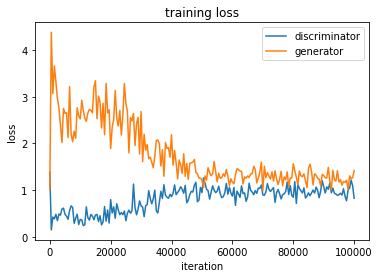

In [9]:
# adversarial training of generator and discriminator

num_it = 100000
log_steps = 10000 #  step size for logging during training
loss_step = 500 # step size to record loss

log_step = 0
t_0 = time.time()
loss_g = []
loss_d = []
for it in range(num_it):
    
    # train discriminator
    _, loss_d_cur = sess.run([net.solver_d, net.loss_d])
    
    # train generator
    _, loss_g_cur = sess.run([net.solver_g, net.loss_g])
    
    if (it + 1) % loss_step == 0 or it == 0:
        loss_d.append(loss_d_cur)
        loss_g.append(loss_g_cur)
    
    if (it + 1) % log_steps == 0 or it == 0:
        t = time.time()
        print('Iter: {}'.format(it+1))
        print('G_loss: {:.4}'.format(loss_g_cur))
        print('D loss: {:.4}'.format(loss_d_cur))
        print('Total runtime {:.2f}s'.format(t - t_0))
        print()

x = np.arange(0, num_it + 1, loss_step)
plt.plot(x, loss_d, label='discriminator')
plt.plot(x, loss_g, label='generator')
plt.title('training loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend();

In [10]:
# generator samples
s = sess.run(net.x_g_pl, feed_dict={net.z_pl: np.random.randn(25, z_dim)})
s = s.reshape((25, 28, 28))
plot(s, figsize=(5, 5), gspec=(5, 5));
plt.clim(0, 1)

In [11]:
tmp = sess.run(net.x_g).reshape((batch_size, 28, 28))
plot(tmp[:25,:,:], figsize=(5, 5), gspec=(5, 5));
plt.clim(0, 1)

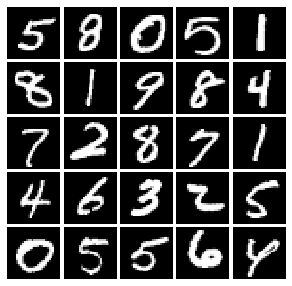

In [12]:
tmp = sess.run(next_element)
tmp = tmp.reshape((batch_size, 28, 28))
plot(tmp[:25,:,:], figsize=(5, 5), gspec=(5, 5));

In [13]:
tmp = sess.run(net.d_x_real_logits)
tmp = 1 / (1 + np.exp(-tmp))
plt.hist(tmp)
plt.title('Discriminator output for real data');
plt.xlim(0, 1);

In [14]:
tmp = sess.run(net.d_x_fake_logits)
tmp = 1 / (1 + np.exp(-tmp))
plt.hist(tmp)
plt.title('Discriminator output for fake data');
plt.xlim(0, 1);